In [28]:
!pip install torch.geometric
!pip install pandas
!pip install matplotlib
!pip install scikit-learn


In [29]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [30]:
df = pd.read_csv("dataset_LUMINAL_A_B.csv")

In [31]:
# Label Extraction
label_column = df.iloc[:, 0]
print(label_column)

0     Luminal A    
1     Luminal A    
2     Luminal A    
3     Luminal A    
4     Luminal A    
          ...      
95    Luminal B    
96    Luminal B    
97    Luminal B    
98    Luminal B    
99    Luminal B    
Name: l, Length: 100, dtype: object


In [32]:
# Transform the target column in a tensor with 'Luminal A' = 0 and 'Luminal B' = 1
labels = torch.tensor(label_column == "Luminal B    ", dtype = torch.long)
print(labels)
print(len(labels))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
100


In [33]:
# Feature extraction
feature_df = df.iloc[:, 1:]
print(feature_df)
print(feature_df.values.dtype)

    ENSG00000242268.2  ENSG00000270112.3  ENSG00000167578.15  \
0         2356.253792       26808.891103        57790.161586   
1            0.000000         231.960840       115769.964478   
2            0.000000         315.873536        44954.933833   
3         1074.333108           0.000000        86991.783442   
4         1395.887715           0.000000        65199.337535   
..                ...                ...                 ...   
95        1145.198255           0.000000        80441.669167   
96           0.000000           0.000000        64247.731360   
97        1584.531801           0.000000       111015.831651   
98           0.000000         178.431416        34013.611358   
99         513.986207           0.000000        33740.054708   

    ENSG00000273842.1  ENSG00000078237.5  ENSG00000146083.10  \
0                 0.0       71389.111749       381288.489078   
1                 0.0       77938.573803       238017.846096   
2                 0.0       58546.99785

In [34]:
# Remove empty features
cols_all_zero = feature_df.columns[(feature_df == 0).all()]
print(f"Found {len(cols_all_zero)} columns with empty values")

feature_cleaned = feature_df.drop(columns = cols_all_zero)

Found 84 columns with empty values


In [35]:
# Extract list of columns
column_list = feature_cleaned.columns
print(column_list)

Index(['ENSG00000242268.2', 'ENSG00000270112.3', 'ENSG00000167578.15',
       'ENSG00000273842.1', 'ENSG00000078237.5', 'ENSG00000146083.10',
       'ENSG00000225275.4', 'ENSG00000158486.12', 'ENSG00000198242.12',
       'ENSG00000259883.1',
       ...
       'ENSG00000088356.5', 'ENSG00000176752.6', 'ENSG00000223082.1',
       'ENSG00000237714.1', 'ENSG00000200959.1', 'ENSG00000270971.2',
       'ENSG00000267313.5', 'ENSG00000151632.15', 'ENSG00000269107.1',
       'ENSG00000268889.1'],
      dtype='object', length=938)


In [36]:
# Scaling --> to avoid exploding gradient
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_cleaned.values)
print(features_scaled)

print(f"Mean: {features_scaled.mean()}")
print(f"Variance: {features_scaled.std()}")
print(f"Shape: {features_scaled.shape}")

[[ 1.91832013e+00  9.14942232e+00 -4.31661045e-01 ... -1.60119274e-01
  -2.02411824e-01 -6.59515199e-01]
 [-5.24109602e-01 -9.13602474e-02  8.31202494e-01 ... -2.76572046e-01
  -2.02411824e-01 -6.59515199e-01]
 [-5.24109602e-01 -6.21838541e-02 -7.11226347e-01 ... -2.43502345e-01
  -2.02411824e-01 -6.59515199e-01]
 ...
 [ 1.11837373e+00 -1.72012891e-01  7.27652280e-01 ... -2.26294930e-01
  -2.02411824e-01  3.40594643e-01]
 [-5.24109602e-01 -1.09972396e-01 -9.49540321e-01 ... -2.96817446e-01
  -2.02411824e-01 -1.18407303e-01]
 [ 8.67476895e-03 -1.72012891e-01 -9.55498684e-01 ... -2.19367046e-01
  -2.02411824e-01 -6.59515199e-01]]
Mean: -1.2167476218706407e-18
Variance: 1.0
Shape: (100, 938)


Facciamo la PCA perchè abbiamo troppe dimensioni e non sarebbe possibile trovare correlazioni sensate tra i pazienti

In [37]:
# PCA
pca = PCA(n_components = 40)

features_pca = pca.fit_transform(features_scaled)

In [38]:
# Create a new dataframe from features_scaled (numpy array)
df_temp = pd.DataFrame(features_pca)
print(df_temp)

           0          1         2         3         4         5          6   \
0   81.850894  66.549995  1.200822 -5.522435 -2.965355 -2.983699   0.242768   
1   -5.443298  -0.684981  2.362835 -1.122696  0.816712 -1.116168  -0.419835   
2   -0.791715  -0.756691 -2.949631  0.607247 -1.824434  0.436707  -4.444809   
3   -2.261583  -1.041681  2.377240 -0.034903 -0.369602 -0.604938  -6.328706   
4   -4.870462  -0.869041 -0.048337 -2.975066  0.513584 -5.299401   3.657203   
..        ...        ...       ...       ...       ...       ...        ...   
95  -1.476305  -1.031058 -4.306311 -0.358866 -0.979771 -5.294072   1.984945   
96  -3.139965  -1.226604 -3.060300 -1.970539 -0.161657 -1.352932   1.973251   
97  -3.843163   0.454258  7.602251 -0.695247 -0.862698  4.057874  11.198700   
98  -0.623382  -0.812974 -3.915267 -4.009662 -1.907419  1.670039  -0.668493   
99  -1.601930   0.882062 -7.858954 -5.613631 -0.838436  1.498604   3.468416   

           7         8         9   ...        30   

In [39]:
# Compute Pearson correlation
pearson_corr = df_temp.T.corr(method="pearson")   # trasposta perchè vogliamo la pearson tra paziente e paziente
print(pearson_corr)

          0         1         2         3         4         5         6   \
0   1.000000 -0.232707 -0.084789 -0.156031 -0.278567 -0.151811 -0.248371   
1  -0.232707  1.000000 -0.139646  0.018910  0.060915  0.217893 -0.179289   
2  -0.084789 -0.139646  1.000000  0.301256 -0.047509  0.014241  0.135626   
3  -0.156031  0.018910  0.301256  1.000000  0.049389  0.040004 -0.052246   
4  -0.278567  0.060915 -0.047509  0.049389  1.000000 -0.226639 -0.089883   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.063876 -0.060818 -0.038313 -0.185738  0.395015 -0.091533  0.133688   
96 -0.288215 -0.002502  0.113120 -0.177087  0.214095 -0.087159  0.152329   
97 -0.066722 -0.084780 -0.105026 -0.115907 -0.005046 -0.107429 -0.107494   
98 -0.033313  0.019105  0.154612  0.003446  0.165424  0.007894 -0.275908   
99 -0.021701  0.063984 -0.088499 -0.085004 -0.056148 -0.057349 -0.058196   

          7         8         9   ...        90        91        92        93  \
0   0.

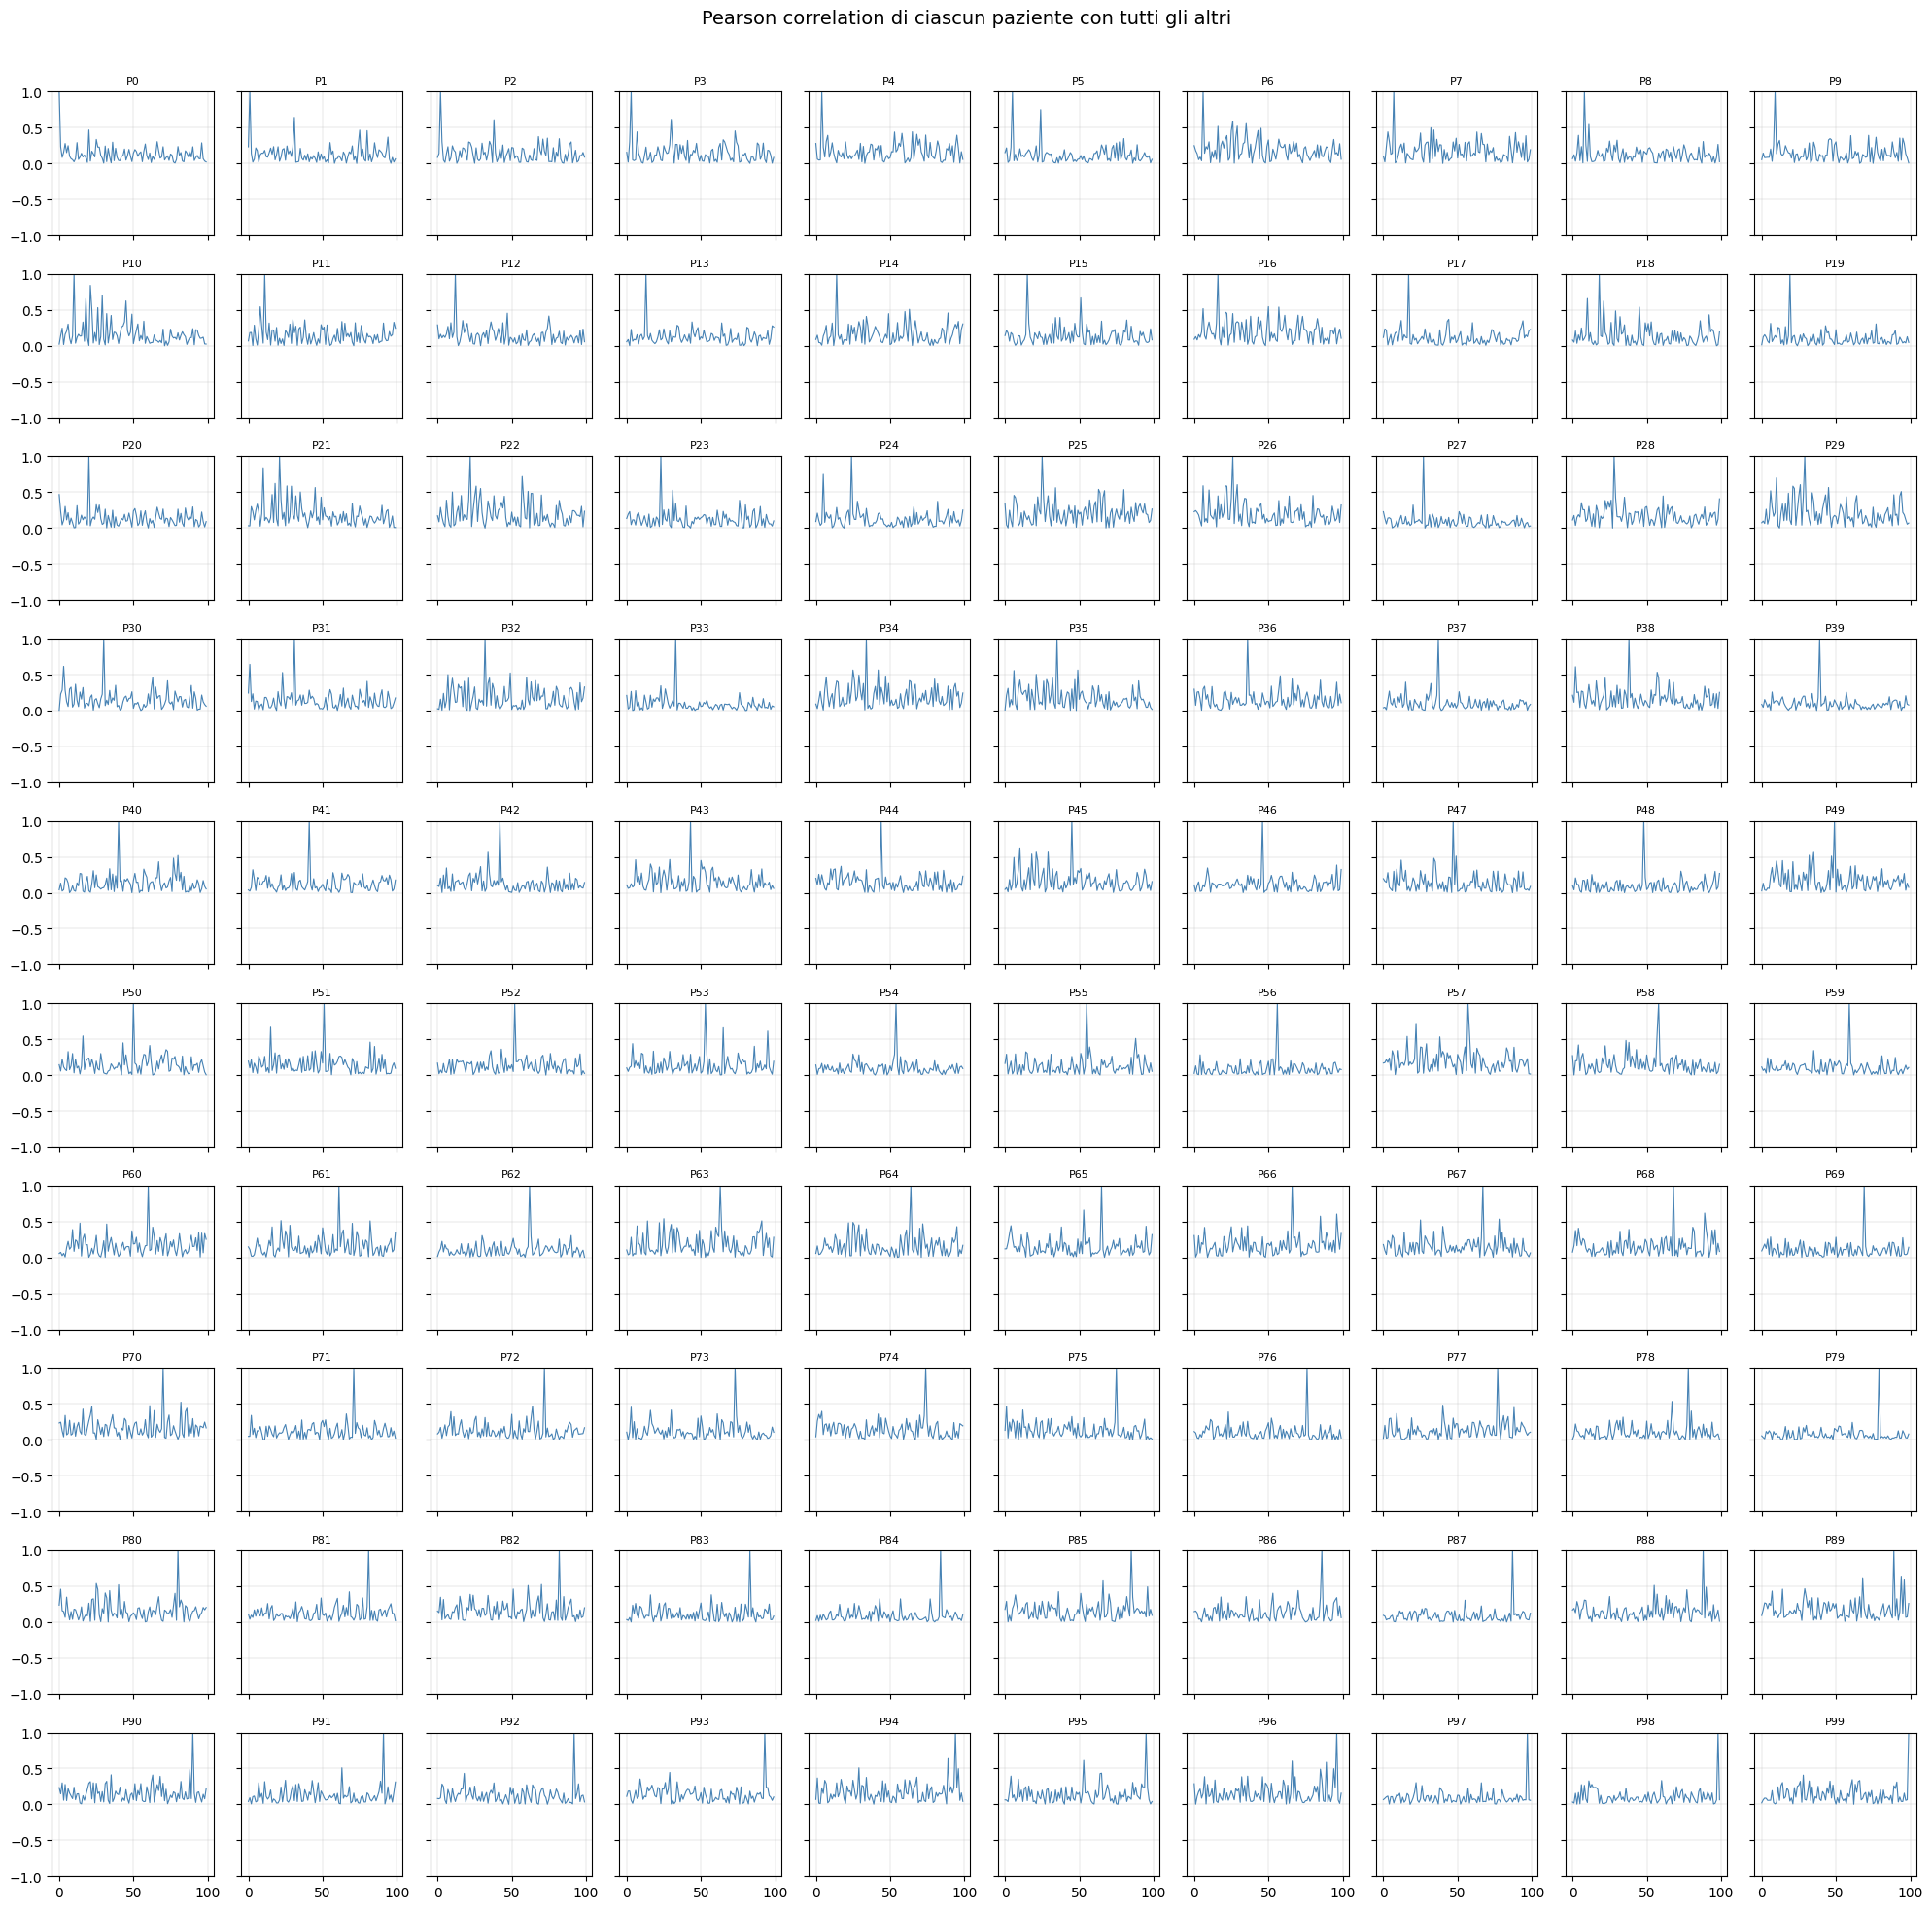

In [40]:
import numpy as np
df_temp = pearson_corr.abs()

n_patients = df_temp.shape[0]  # es. 100
cols = 10                 # numero di colonne nella griglia
rows = int(np.ceil(n_patients / cols))

fig, axes = plt.subplots(rows, cols, figsize=(20, 20), sharex=True, sharey=True)

# imposta limiti coerenti per tutti i plot
ymin, ymax = -1, 1

for i, ax in enumerate(axes.flat):
    if i < n_patients:
        ax.plot(df_temp.iloc[i, :].values, color='steelblue', linewidth=0.8)
        ax.set_title(f"P{i}", fontsize=8)
        ax.set_ylim(ymin, ymax)
        ax.grid(True, linewidth=0.2)
    else:
        ax.axis('off')  # spazi vuoti se non serve

fig.suptitle("Pearson correlation di ciascun paziente con tutti gli altri", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

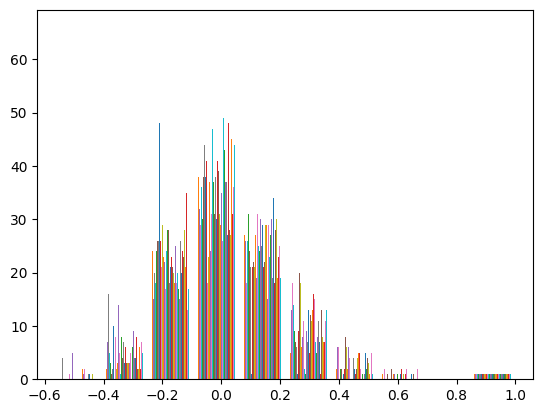

In [41]:
# Plot values
plt.hist(pearson_corr)
plt.show()

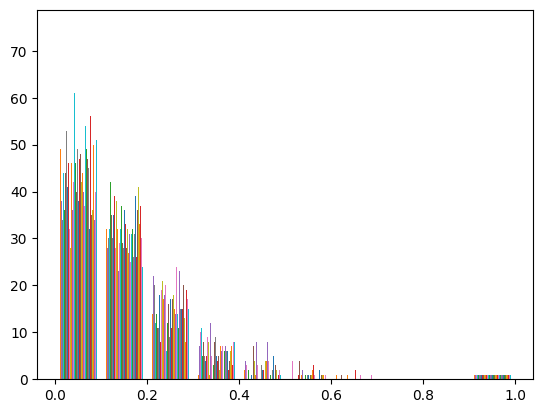

In [42]:
# Plot the df with abs to keep all the correlations (also the negative ones)
pearson_abs = pearson_corr.abs()
plt.hist(pearson_abs)
plt.show()

          0         1         2         3         4         5         6   \
0   1.000000  0.138122  0.089385  0.160348  0.035008 -0.024482  0.037060   
1   0.138122  1.000000  0.050045 -0.176514  0.090057  0.313543  0.043132   
2   0.089385  0.050045  1.000000  0.145707  0.194539 -0.128077  0.008209   
3   0.160348 -0.176514  0.145707  1.000000 -0.045941 -0.046601  0.074191   
4   0.035008  0.090057  0.194539 -0.045941  1.000000  0.027051  0.014389   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.038332  0.046613 -0.134569  0.097990  0.107903 -0.059994  0.178626   
96  0.171737 -0.152331 -0.017378  0.018446  0.036688 -0.019298  0.132841   
97  0.060450  0.230135  0.321032  0.016070 -0.007621  0.058566  0.112211   
98 -0.034035  0.176274 -0.031251 -0.178614 -0.019574 -0.073327 -0.083696   
99  0.115716 -0.086901  0.034551  0.046133 -0.091101 -0.016922 -0.049889   

          7         8         9   ...        90        91        92        93  \
0   0.

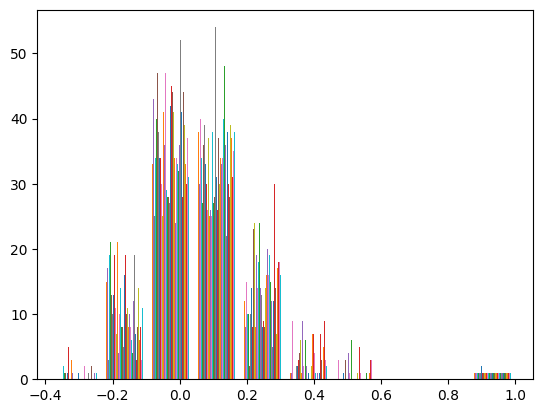

In [43]:
# Compute Spearman correlation
spearman_corr = df_temp.T.corr(method="spearman")
print(spearman_corr)

# Plot
plt.hist(spearman_corr)
plt.show()

          0         1         2         3         4         5         6   \
0   1.000000  0.100606  0.065051  0.104646  0.024242 -0.012121  0.024646   
1   0.100606  1.000000  0.029495 -0.120808  0.063838  0.220606  0.031919   
2   0.065051  0.029495  1.000000  0.099798  0.142222 -0.085657  0.006869   
3   0.104646 -0.120808  0.099798  1.000000 -0.034747 -0.025051  0.048081   
4   0.024242  0.063838  0.142222 -0.034747  1.000000  0.018990  0.000000   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.016566  0.027879 -0.090101  0.066667  0.071919 -0.037172  0.120808   
96  0.117980 -0.109899 -0.007273  0.012121  0.027879 -0.012525  0.085657   
97  0.034343  0.165253  0.213737  0.010101 -0.004040  0.038788  0.077172   
98 -0.025051  0.113131 -0.020202 -0.118788 -0.019798 -0.056162 -0.058990   
99  0.075960 -0.057374  0.026667  0.021010 -0.055354 -0.010101 -0.034747   

          7         8         9   ...        90        91        92        93  \
0   0.

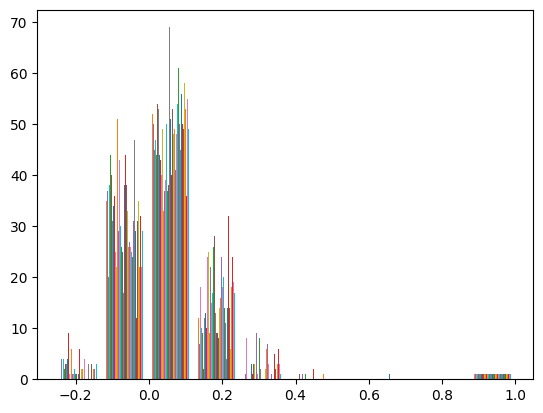

In [44]:
# Compute Kendall correlation
kendall_corr = df_temp.T.corr(method="kendall")
print(kendall_corr)

# Plot
plt.hist(kendall_corr)
plt.show()



Spearman boh Kendall fa schifo





## Threshold


In [45]:
# Transform pearson_abs in tensor

pearson_abs_tensor = torch.tensor(pearson_abs.values, dtype=torch.float32)
pearson_abs_tensor

tensor([[1.0000, 0.2327, 0.0848,  ..., 0.0667, 0.0333, 0.0217],
        [0.2327, 1.0000, 0.1396,  ..., 0.0848, 0.0191, 0.0640],
        [0.0848, 0.1396, 1.0000,  ..., 0.1050, 0.1546, 0.0885],
        ...,
        [0.0667, 0.0848, 0.1050,  ..., 1.0000, 0.0628, 0.0568],
        [0.0333, 0.0191, 0.1546,  ..., 0.0628, 1.0000, 0.0648],
        [0.0217, 0.0640, 0.0885,  ..., 0.0568, 0.0648, 1.0000]])

In [46]:
# Compute the edge list

edges = []

for i in range(pearson_abs.shape[0]):
  for j in range (pearson_abs.shape[1]):
    if i == j:
      continue

    if pearson_abs.iloc[i, j] > 0.4:
      edges.append((i, j))

print(edges)

[(0, 20), (1, 31), (1, 75), (1, 80), (2, 38), (3, 7), (3, 30), (3, 73), (4, 53), (4, 58), (4, 65), (4, 68), (5, 24), (6, 16), (6, 25), (6, 26), (6, 29), (6, 35), (6, 43), (6, 45), (7, 3), (7, 25), (7, 32), (7, 34), (7, 63), (7, 66), (7, 89), (8, 11), (10, 18), (10, 21), (10, 22), (10, 26), (10, 29), (10, 32), (10, 35), (10, 45), (10, 49), (11, 8), (12, 47), (12, 75), (14, 34), (14, 49), (14, 60), (14, 63), (14, 89), (15, 51), (16, 6), (16, 21), (16, 22), (16, 26), (16, 38), (16, 43), (16, 50), (16, 57), (16, 61), (16, 70), (16, 73), (18, 10), (18, 21), (18, 29), (18, 32), (18, 45), (18, 92), (20, 0), (21, 10), (21, 16), (21, 18), (21, 26), (21, 29), (21, 32), (21, 35), (21, 45), (21, 49), (22, 10), (22, 16), (22, 25), (22, 26), (22, 29), (22, 38), (22, 45), (22, 57), (22, 58), (22, 61), (22, 63), (22, 64), (22, 70), (23, 31), (24, 5), (25, 6), (25, 7), (25, 22), (25, 26), (25, 29), (25, 34), (25, 63), (25, 64), (25, 66), (25, 67), (25, 80), (26, 6), (26, 10), (26, 16), (26, 21), (26, 2

In [47]:
len(edges)

318

In [48]:
# la GNN vuole un tensore di shape (2, num_edges)
edge_index = torch.tensor(edges).T
print(edge_index)

tensor([[ 0,  1,  1,  1,  2,  3,  3,  3,  4,  4,  4,  4,  5,  6,  6,  6,  6,  6,
          6,  6,  7,  7,  7,  7,  7,  7,  7,  8, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 11, 12, 12, 14, 14, 14, 14, 14, 15, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 18, 18, 18, 18, 18, 18, 20, 21, 21, 21, 21, 21, 21, 21, 21,
         21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 24, 25, 25,
         25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26,
         26, 26, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
         29, 29, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32,
         34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 35,
         35, 36, 36, 36, 38, 38, 38, 38, 38, 38, 40, 40, 40, 42, 43, 43, 43, 43,
         45, 45, 45, 45, 45, 45, 47, 47, 47, 47, 49, 49, 49, 49, 49, 49, 50, 50,
         50, 51, 51, 51, 53, 53, 53, 53, 55, 57, 57, 57, 57, 57, 58, 58, 58, 58,
         58, 60, 60, 60, 61,

In [49]:
# Masking

num_nodes = pearson_abs.shape[0]

num_train = int(0.7 * num_nodes)
num_test = int(0.3 * num_nodes)

# Random permutation of the indices
perm = torch.randperm(num_nodes)

train_idx = perm[: num_train]
test_idx = perm[num_train :]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx]=True
test_mask[test_idx]=True

In [50]:
# training

class GCN(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, output_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(input_channels=pearson_abs.shape[0], hidden_channels=8, output_channels=2)
print(model)

GCN(
  (conv1): GCNConv(100, 8)
  (conv2): GCNConv(8, 2)
)


In [51]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(pearson_abs_tensor, edge_index)  # Perform a single forward pass.
      loss = criterion(out[train_mask], labels[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(pearson_abs_tensor, edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[test_mask] == labels[test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 0.6918
Epoch: 002, Loss: 0.6698
Epoch: 003, Loss: 0.6812
Epoch: 004, Loss: 0.6683
Epoch: 005, Loss: 0.6521
Epoch: 006, Loss: 0.6622
Epoch: 007, Loss: 0.6538
Epoch: 008, Loss: 0.6124
Epoch: 009, Loss: 0.6482
Epoch: 010, Loss: 0.6435
Epoch: 011, Loss: 0.6323
Epoch: 012, Loss: 0.5976
Epoch: 013, Loss: 0.6334
Epoch: 014, Loss: 0.6171
Epoch: 015, Loss: 0.5917
Epoch: 016, Loss: 0.5952
Epoch: 017, Loss: 0.5991
Epoch: 018, Loss: 0.5607
Epoch: 019, Loss: 0.5853
Epoch: 020, Loss: 0.5807
Epoch: 021, Loss: 0.5481
Epoch: 022, Loss: 0.5404
Epoch: 023, Loss: 0.5380
Epoch: 024, Loss: 0.5152
Epoch: 025, Loss: 0.5288
Epoch: 026, Loss: 0.5149
Epoch: 027, Loss: 0.4907
Epoch: 028, Loss: 0.5227
Epoch: 029, Loss: 0.5250
Epoch: 030, Loss: 0.4530
Epoch: 031, Loss: 0.4936
Epoch: 032, Loss: 0.4710
Epoch: 033, Loss: 0.4914
Epoch: 034, Loss: 0.4473
Epoch: 035, Loss: 0.4998
Epoch: 036, Loss: 0.4941
Epoch: 037, Loss: 0.4415
Epoch: 038, Loss: 0.4679
Epoch: 039, Loss: 0.4822
Epoch: 040, Loss: 0.4450


In [52]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

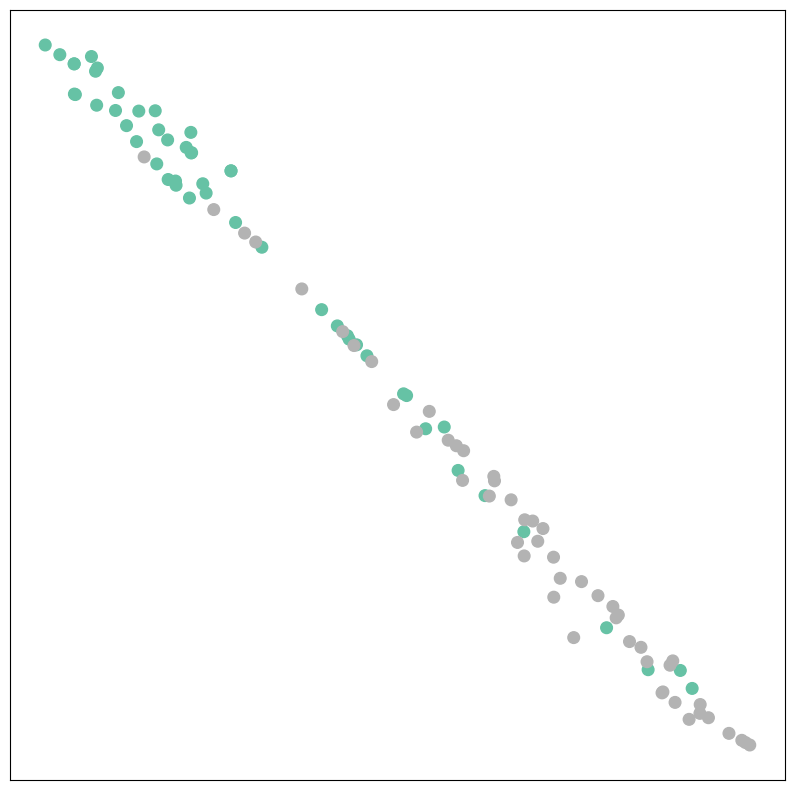

In [53]:
model.eval()
out = model(pearson_abs_tensor, edge_index)
visualize(out, color=labels)

## KNN

## Adjacency matrix non binary
